# Vector analysis

analyzing wind vectors. code by Noel Wang, based on other stuff in AK_polynya environment

## importing packages

In [1]:
# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import matplotlib.dates as mdates

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
from matplotlib import colors as mcolors

# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat

# for use in suppressing repeated warnings when mapping w/ shapely
import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

# path to own functions
sys.path.append('../Libraries_functions/')
from LIB_ASI_SIC_UniB import grab_ASI_SIC, grab_projinfo_SIC
from LIB_geo_func import *
from LIB_geo_plot import *


# OSI SAF sea ice drift
from LIB_OSI_SAF import grab_projinfo_OSISAF, grab_OSISAF_drift

# NSIDC sea ice drift
from LIB_PPdrift_NSIDC0116 import grab_projinfo_PPdrift

# ERA5
# from LIB_access_ERA5 import grab_ERA5

%load_ext autoreload
%autoreload 2
# potentially uninstall pyhdf?

# math
import math

#scipy
from scipy import stats

## determining The Vector

In [25]:
year = 2018

# importing the CSV files

#read in the data files
df_hourly_wind = pd.read_csv(f"/Users/reu/Box/Data/{year}wind_hourly.csv")
df_daily_size = pd.read_csv(f"/Users/reu/Box/Data/{year}SIC.csv")
df_daily_wind = pd.read_csv(f"/Users/reu/Box/Data/{year}wind_daily.csv")
df_upwelling = pd.read_csv(f"/Users/reu/Box/Data/{year}upwelling_hourly.csv")

#converting the times to the correct format
time_daily = pd.to_datetime(df_daily_size.time)
time_hourly = pd.to_datetime(df_hourly_wind.time)

#initialize an empty list
angles_list = []
mag_list = []

#make dictionary of the u:v values
uv_list = list(zip(df_hourly_wind.u10_average_m_s, df_hourly_wind.v10_average_m_s))
uv_list_daily = list(zip(df_daily_wind.u10_average_m_s, df_daily_wind.v10_average_m_s))

#calculate the angle and magnitude with trigonometry
i = 0
while i < len(df_hourly_wind):
    angle =math.degrees((np.arctan2(df_hourly_wind.v10_average_m_s[i], df_hourly_wind.u10_average_m_s[i]))) % 360
    # print(f'The angle in iteration {i} is {angle}, calculated by taking {df_hourly_wind.v10_average_m_s[i]} / {(df_hourly_wind.u10_average_m_s[i])}')
    angles_list.append(angle)
    
    mag = np.linalg.norm(uv_list[i])
    mag_list.append(mag)
    
    i +=1

#rcostheta = u, rsintheta = v. r = 17 m/s. theta = 157.5 degrees
theVector = [17* math.cos(math.radians(157.5)), 17* math.sin(math.radians(157.5))]
print(theVector)

#calculate the projection (hourly)
i = 0
proj_list = []
while i < len(uv_list):
    proj = np.dot(uv_list[i], theVector) / np.linalg.norm(theVector)
    proj_list.append(proj)
    i+=1

#calculate the projection (daily)
j = 0
proj_list_daily = []
while j < len(uv_list_daily):
        proj_daily = np.dot(uv_list_daily[j], theVector) / np.linalg.norm(theVector)
        proj_list_daily.append(proj_daily)
        j+=1
print(len(proj_list_daily))


[-15.705952052691874, 6.505618350206527]
62


## export to CSV

In [79]:
#including Jan 31st, hourly
d = {'time': time_hourly, 'angle': angles_list, 'mag': mag_list, 'u': df_hourly_wind.u10_average_m_s, 'v': df_hourly_wind.v10_average_m_s, 'projlist': proj_list}
df = pd.DataFrame(data=d)
df.to_csv(f'/Users/reu/Box/Data/{year}angles_hourly.csv', index=None) #removes Index column

#including Jan 31st, daily
d = {'time': time_daily, 'u': df_daily_wind.u10_average_m_s, 'v': df_daily_wind.v10_average_m_s, 'projlist': proj_list_daily}
df = pd.DataFrame(data=d)
df.to_csv(f'/Users/reu/Box/Data/{year}angles_daily.csv', index=None) #removes Index column

## make stacked angles plots

Text(0.5, 0.98, 'Stacked angles plot from 01-Dec-2017 to 31-Jan-2018 over polynya')

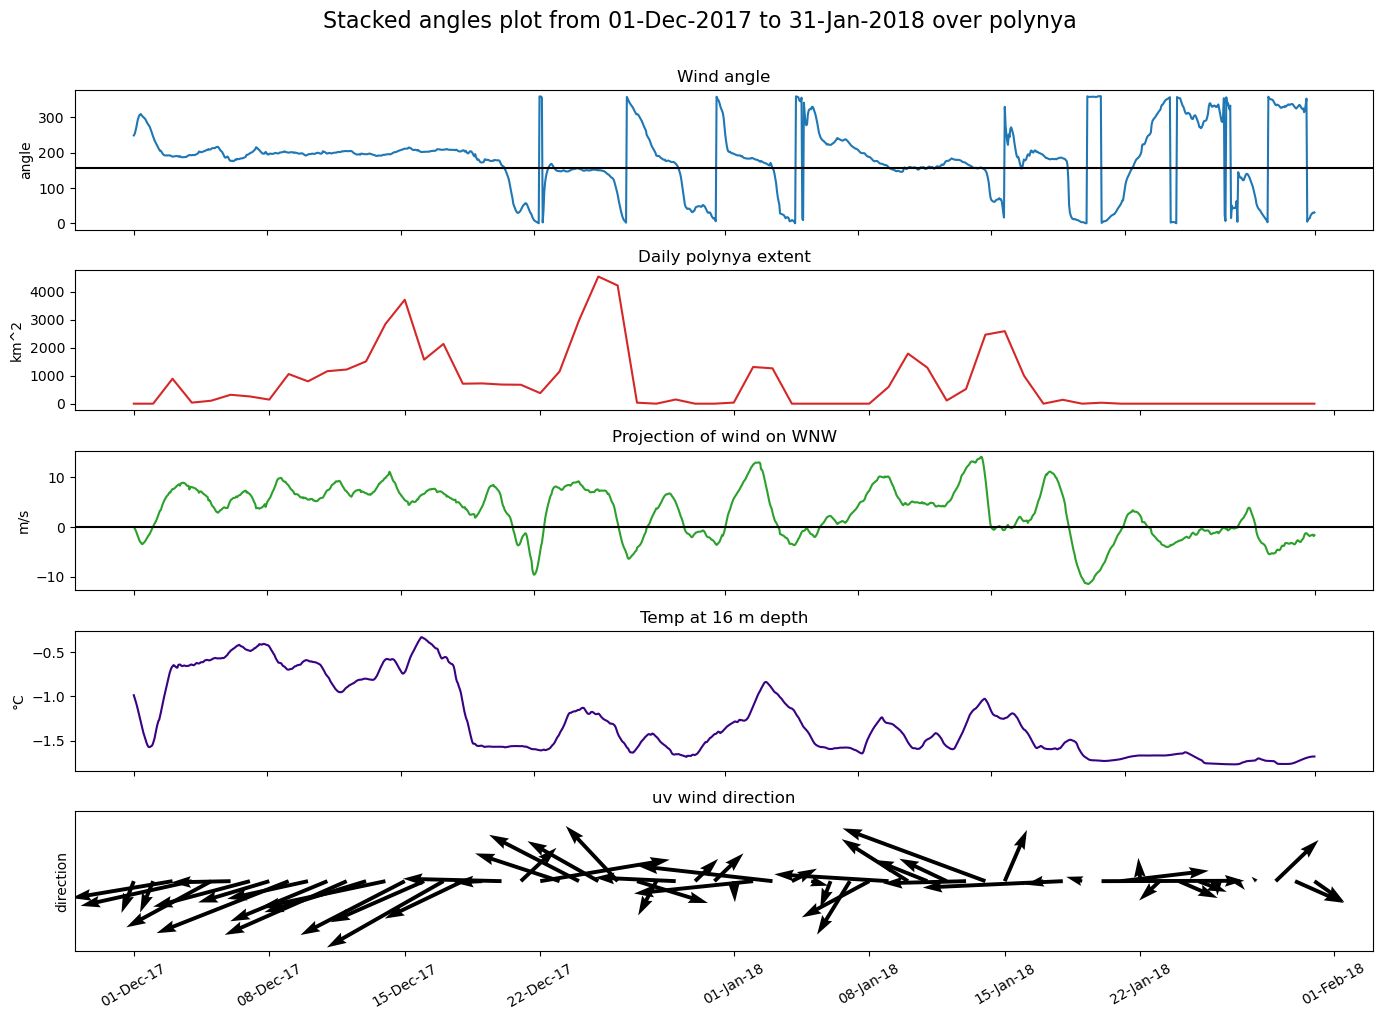

In [82]:
#plot stacked plots

fig, ax = plt.subplots(5, 1, figsize = (14,10))

labeldata = ("angle", "km^2", "m/s", "°C", "direction")

for i, (unit) in enumerate(labeldata):
    ax[i].set_ylabel(unit)
    # ax[i].axvspan(datetime(2024, 1,3), datetime(2024, 1, 17), facecolor='lightgray', alpha=0.2)

plt.tight_layout()
fig.subplots_adjust(top=.9)

ax[0].plot(time_hourly, angles_list, 'tab:blue', label='uv wind (m/s)')
ax[0].set_title('Wind angle')
ax[0].axhline(157.5, color = 'black')
# ax[0].set_ylim(0,20)

ax[1].plot(time_daily, df_daily_size.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[1].set_title('Daily polynya extent')

ax[2].plot(time_hourly, proj_list, 'tab:green')
ax[2].set_title('Projection of wind on WNW')
ax[2].axhline(0, color = 'black')

ax[3].plot(time_hourly, df_upwelling.Tmean_C, 'xkcd:indigo')
ax[3].set_title('Temp at 16 m depth')

y = np.zeros_like(time_daily)
qv = plt.quiver(time_daily, y, df_daily_wind.u10_average_m_s, df_daily_wind.v10_average_m_s, width=0.003)
qk = ax[4].quiverkey(qv, 10, 10, 5, r'$20 \frac{km}{day}$',labelpos='E' )
ax[4].set_title('uv wind direction')
ax[4].set_yticks([])

for ax in ax.flat:
    ax.label_outer()

plt.xticks(rotation=30)
# plt.xticks(time_daily)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

plt.suptitle(f'Stacked angles plot from {time_daily[0].strftime("%d-%b-%Y")} to {time_daily[len(time_daily) - 1].strftime("%d-%b-%Y")} over polynya', fontsize=16)
#highlighting the polynya formation

## scatter area/extent vs. proj

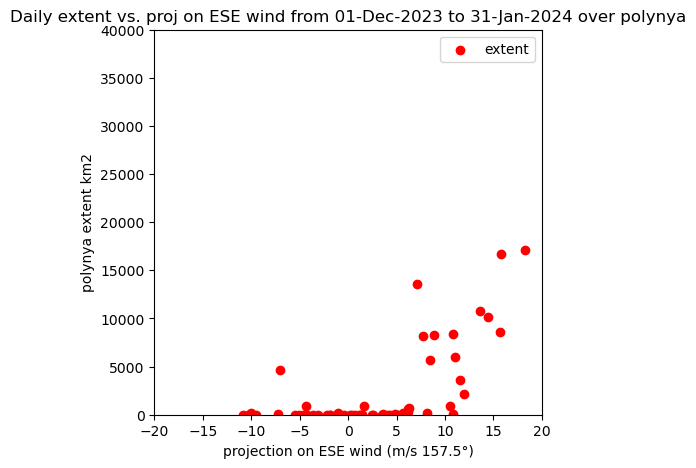

In [24]:
year2 = 2024

df_daily_size_mask = pd.read_csv(f"/Users/reu/Box/Data/{year2}SIC.csv")
df_daily_wind = pd.read_csv(f"/Users/reu/Box/Data/{year2}wind_daily.csv")
time_daily = pd.to_datetime(df_daily_size_mask.time)
uv_list_daily = list(zip(df_daily_wind.u10_average_m_s, df_daily_wind.v10_average_m_s))

#rcostheta = u, rsintheta = v. r = 17 m/s. theta = 157.5 degrees
theVector = [17* math.cos(math.radians(157.5)), 17* math.sin(math.radians(157.5))]


#calculate the projection (daily)
j = 0
proj_list_daily = []
while j < len(uv_list_daily):
        proj_daily = np.dot(uv_list_daily[j], theVector) / np.linalg.norm(theVector)
        proj_list_daily.append(proj_daily)
        j+=1

#Scatter plot of polynya extent on Projection

fig, ax = plt.subplots(figsize = (5,5))
color = 'tab:red'

x = proj_list_daily
y = df_daily_size_mask.Open_water_area_km2
z = df_daily_size_mask.Open_water_extent_km2

ax.set_xlabel('projection on ESE wind (m/s 157.5°)')
ax.set_ylabel('polynya extent km2')
ax.set_xlim(-20, 20)
ax.set_ylim(0, 40000)
# ax.scatter(x, y, color = "blue", label = 'area')
ax.scatter(x, z, color = 'red', label = 'extent')
plt.legend()

plt.title(f'Daily extent vs. proj on ESE wind from {time_daily[0].strftime("%d-%b-%Y")} to {time_daily[len(time_daily) - 1].strftime("%d-%b-%Y")} over polynya', fontsize=12)

# #calculating stats
# array_x = np.array(x)
# array_y = np.array(y)
# ziplist = (zip(array_x, array_y))
        
# slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
# plt.plot(array_x, slope*array_x+intercept, color = 'black')
# plt.annotate("y=%.3fx+%.3f\nR$^2$=%.3f\np=%.3f"%(slope,intercept,rvalue**2,pvalue),xy=(1.2,0.7),xycoords='figure fraction')

### including Jan 31st
d = {'proj_daily': proj_list_daily, 'area_km2': y, 'extent_km2': z}
df = pd.DataFrame(data=d)
df.to_csv(f'/Users/reu/Box/Data/{year2}scatter.csv', index=None) #removes Index column

# #save figure, if desired
save_path = f'/Users/reu/Box/Plots/{year2}_scatter_EXTENT.png'
fig.savefig(save_path, dpi=300, bbox_inches = 'tight')
# maps_list.append(save_path)

# plt.axis('scaled')

## accumulated

In [6]:
year2 = 2024

df_daily_size_mask = pd.read_csv(f"/Users/reu/Box/Data/{year2}SIC.csv")
df_daily_wind = pd.read_csv(f"/Users/reu/Box/Data/{year2}wind_daily.csv")
time_daily = pd.to_datetime(df_daily_size_mask.time)
uv_list_daily = list(zip(df_daily_wind.u10_average_m_s, df_daily_wind.v10_average_m_s))

#rcostheta = u, rsintheta = v. r = 17 m/s. theta = 157.5 degrees
theVector = [17* math.cos(math.radians(157.5)), 17* math.sin(math.radians(157.5))]


#calculate the projection (daily)
j = 0
proj_list_daily = []
while j < len(uv_list_daily):
        proj_daily = np.dot(uv_list_daily[j], theVector) / np.linalg.norm(theVector)
        proj_list_daily.append(proj_daily)
        j+=1

#Scatter plot of polynya size on Projection

fig, ax = plt.subplots(figsize = (5,5))
color = 'tab:blue'

x = (proj_list_daily)
y = df_daily_size_mask.Open_water_area_km2

print(len(x))
print(len(y))

ax.set_xlabel('projection on ESE wind (m/s 157.5°)')
ax.set_ylabel('polynya area km2')
ax.set_xlim(-20, 20)
ax.set_ylim(0, 40000)
ax.scatter(x, y, color = "blue")


plt.title(f'Daily area vs. proj on ESE wind from {time_daily[0].strftime("%d-%b-%Y")} to {time_daily[len(time_daily) - 1].strftime("%d-%b-%Y")} over polynya', fontsize=12)

# #calculating stats
# array_x = np.array(x)
# array_y = np.array(y)
# zip = (zip(array_x, array_y))
# positive_list = []

# for i in range (len(zip)):
#     if array_x[i][0] > 0:
#         positive_list.append(array_x[i][0])

# print(positive_list)
        

# slope, intercept, rvalue, pvalue, stderr = stats.linregress(x,y)
# plt.plot(array_x, slope*array_x+intercept, color = 'black')
# plt.annotate("y=%.3fx+%.3f\nR$^2$=%.3f\np=%.3f"%(slope,intercept,rvalue**2,pvalue),xy=(0.7,0.7),xycoords='figure fraction')

# including Jan 31st
d = {'proj_daily': proj_list_daily, 'area': y}
df = pd.DataFrame(data=d)
df.to_csv(f'/Users/reu/Desktop/second{year2}scatter.csv', index=None) #removes Index column

# plt.axis('scaled')

TypeError: 'zip' object is not callable

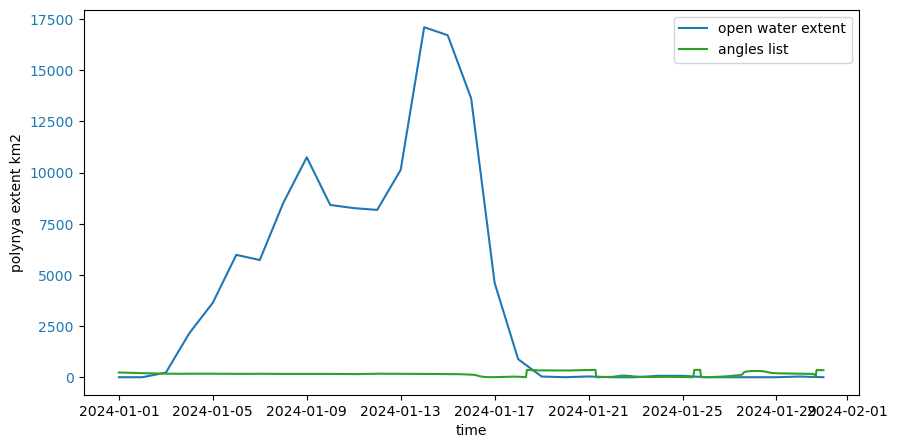

In [13]:
#layered
fig, ax1 = plt.subplots(figsize = (10, 5))
color = 'tab:blue'
ax1.set_xlabel('time')
ax1.set_ylabel('polynya extent km2')
ax1.plot(time_daily, df_daily_size.Open_water_extent_km2, color = color, label = 'open water extent')
ax1.tick_params(axis = 'y', labelcolor = color)
ax1.plot(time_hourly, angles_list, 'tab:green', label='angles list')
plt.legend()

# plt.axis('scaled')


In [ ]:
averagers = [353.157652436921,354.344072 , 355.3992679, 354.46230707747, 356.481335420866 , 359.104098127688]
np.average(averagers)

## Area and extent vs. time

Text(0.5, 0.98, 'Area and extent vs. time')

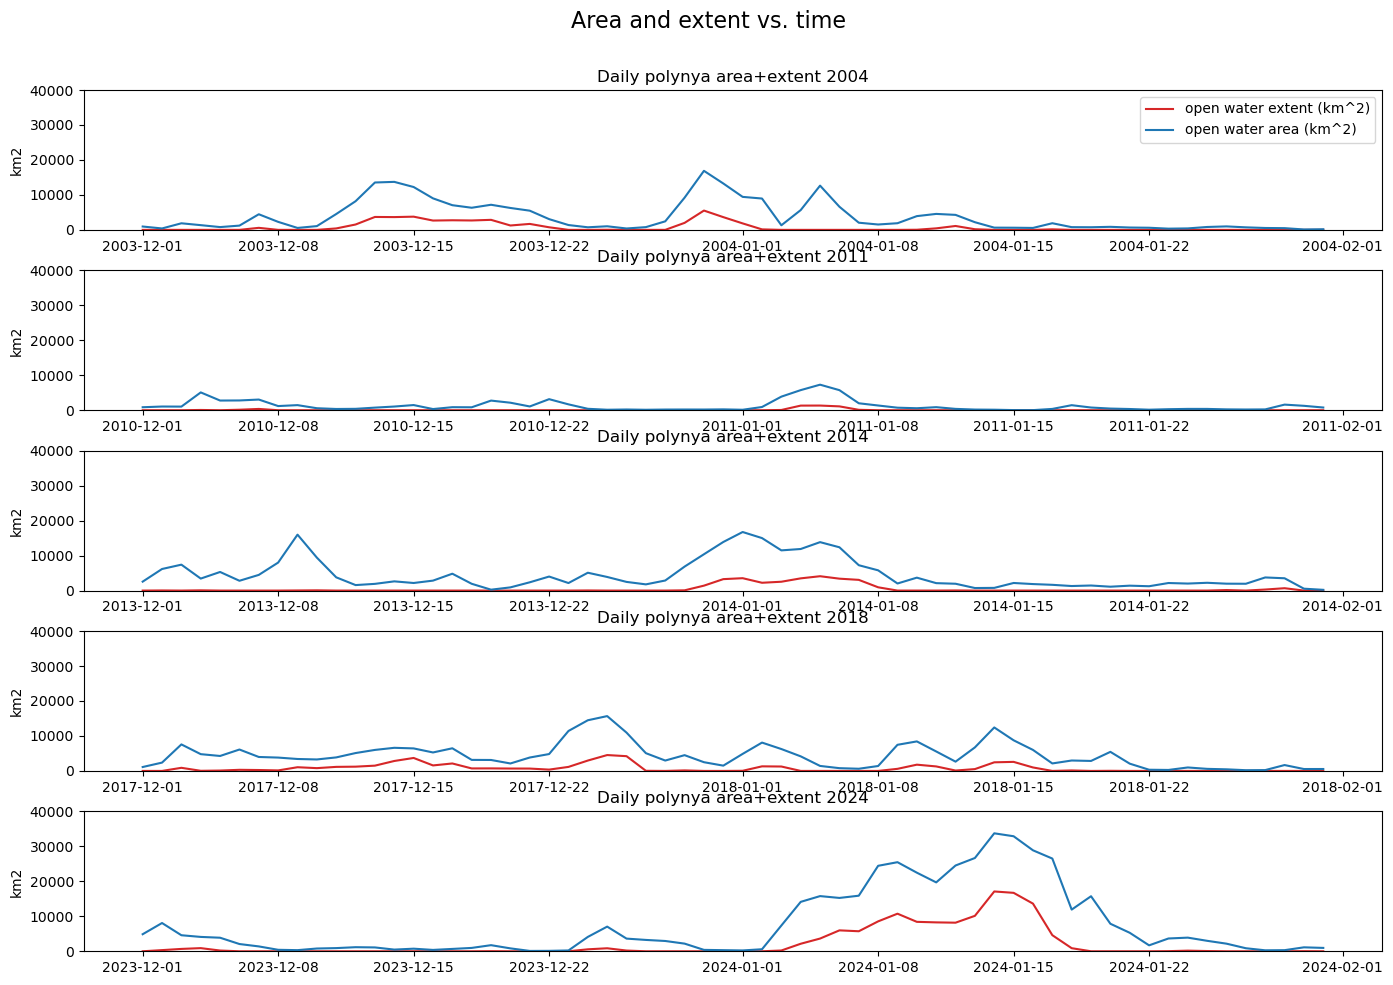

In [55]:
#read in the data files
df_daily_size_2004 = pd.read_csv("/Users/reu/Box/Data/2004SIC.csv")
df_daily_size_2011 = pd.read_csv("/Users/reu/Box/Data/2011SIC.csv")
df_daily_size_2014 = pd.read_csv("/Users/reu/Box/Data/2014SIC.csv")
df_daily_size_2018 = pd.read_csv("/Users/reu/Box/Data/2018SIC.csv")
df_daily_size_2024 = pd.read_csv("/Users/reu/Box/Data/2024SIC.csv")

#converting the times to the correct format
time_daily_2004 = pd.to_datetime(df_daily_size_2004.time)
time_daily_2011 = pd.to_datetime(df_daily_size_2011.time)
time_daily_2014 = pd.to_datetime(df_daily_size_2014.time)
time_daily_2018 = pd.to_datetime(df_daily_size_2018.time)
time_daily_2024 = pd.to_datetime(df_daily_size_2024.time)

#plotting stacked plots
fig, ax = plt.subplots(5, 1, figsize = (14,10))

labeldata = ("km2", "km2", "km2", "km2", "km2")

for i, (unit) in enumerate(labeldata):
    ax[i].set_ylabel(unit)
plt.tight_layout()
fig.subplots_adjust(top=.9)

ax[0].plot(time_daily_2004, df_daily_size_2004.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[0].set_title('Daily polynya extent 2004')
ax[0].plot(time_daily_2004, df_daily_size_2004.Open_water_area_km2, 'tab:blue', label = 'open water area (km^2)')
ax[0].set_title('Daily polynya area+extent 2004')
ax[0].set_ylim(0, 40000)

ax[1].plot(time_daily_2011, df_daily_size_2011.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[1].set_title('Daily polynya extent 2011')
ax[1].plot(time_daily_2011, df_daily_size_2011.Open_water_area_km2, 'tab:blue', label = 'open water area (km^2)')
ax[1].set_title('Daily polynya area+extent 2011')
ax[1].set_ylim(0, 40000)

ax[2].plot(time_daily_2014, df_daily_size_2014.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[2].set_title('Daily polynya extent 2014')
ax[2].plot(time_daily_2014, df_daily_size_2014.Open_water_area_km2, 'tab:blue', label = 'open water area (km^2)')
ax[2].set_title('Daily polynya area+extent 2014')
ax[2].set_ylim(0, 40000)

ax[3].plot(time_daily_2018, df_daily_size_2018.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[3].set_title('Daily polynya extent 2018')
ax[3].plot(time_daily_2018, df_daily_size_2018.Open_water_area_km2, 'tab:blue', label = 'open water area (km^2)')
ax[3].set_title('Daily polynya area+extent 2018')
ax[3].set_ylim(0, 40000)

ax[4].plot(time_daily_2024, df_daily_size_2024.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
ax[4].set_title('Daily polynya extent 2024')
ax[4].plot(time_daily_2024, df_daily_size_2024.Open_water_area_km2, 'tab:blue', label = 'open water area (km^2)')
ax[4].set_title('Daily polynya area+extent 2024')
ax[4].set_ylim(0, 40000)

ax[0].legend()

# for ax in ax.flat:
#     ax.label_outer()

# plt.xticks(rotation=30)
# # plt.xticks(time_daily)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

plt.suptitle(f'Area and extent vs. time', fontsize=16)
#highlighting the polynya formation

## size/projection vs. time

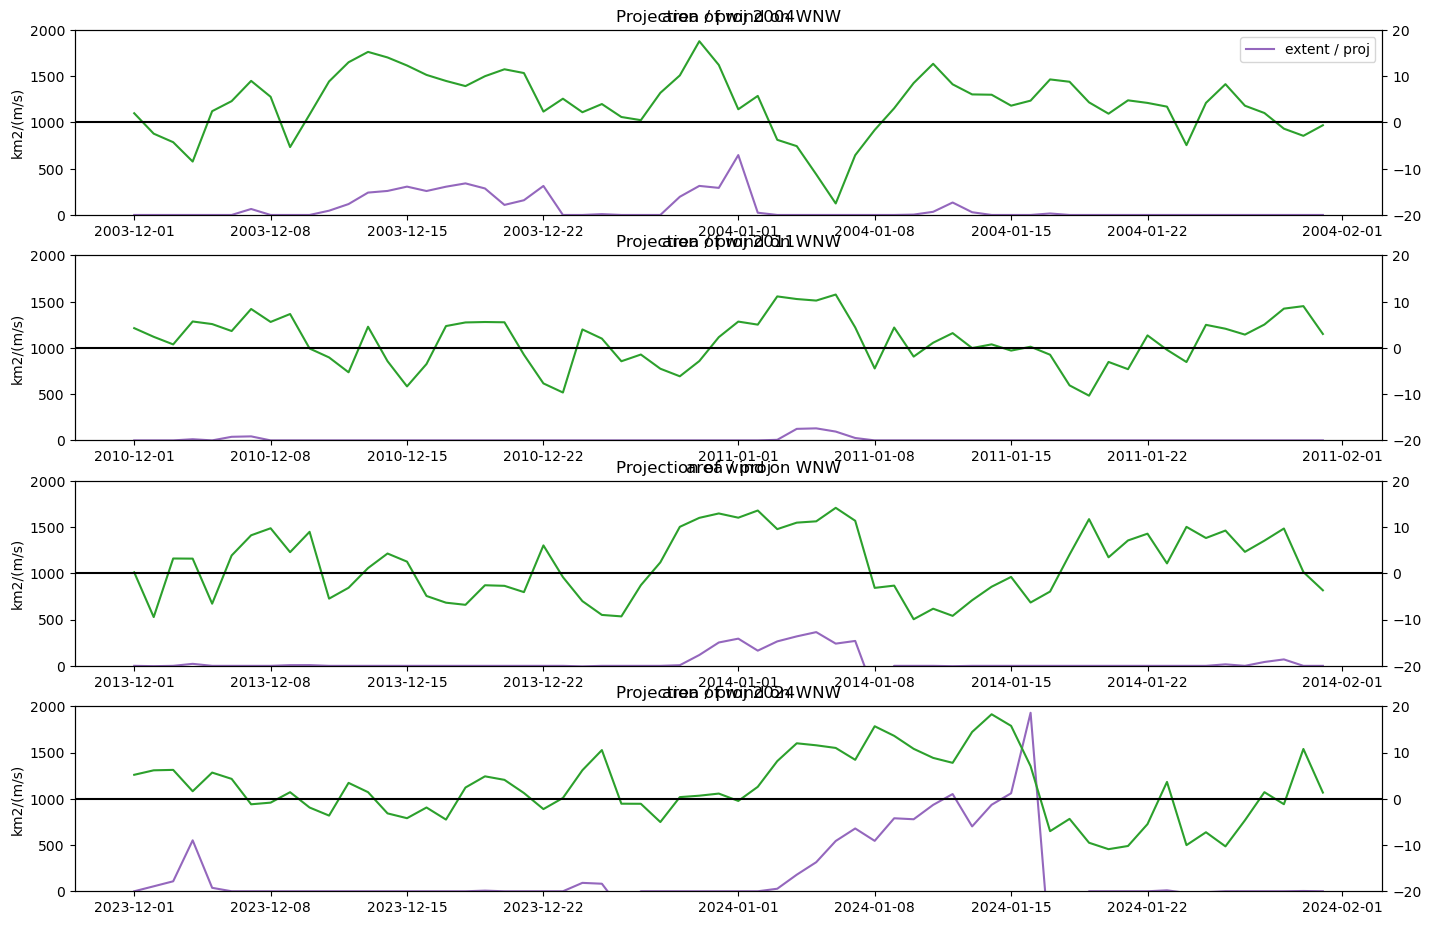

In [67]:
#read in the data files

#size
df_daily_size_2004 = pd.read_csv("/Users/reu/Box/Data/2004SIC.csv")
df_daily_size_2011 = pd.read_csv("/Users/reu/Box/Data/2011SIC.csv")
df_daily_size_2014 = pd.read_csv("/Users/reu/Box/Data/2014SIC.csv")
df_daily_size_2024 = pd.read_csv("/Users/reu/Box/Data/2024SIC.csv")

#wind
df_daily_proj_2004 = pd.read_csv("/Users/reu/Box/Data/2004angles_daily.csv")
df_daily_proj_2011 = pd.read_csv("/Users/reu/Box/Data/2011angles_daily.csv")
df_daily_proj_2014 = pd.read_csv("/Users/reu/Box/Data/2014angles_daily.csv")
df_daily_proj_2024 = pd.read_csv("/Users/reu/Box/Data/2024angles_daily.csv")


#converting the times to the correct format
time_daily_2004 = pd.to_datetime(df_daily_size_2004.time)
time_daily_2011 = pd.to_datetime(df_daily_size_2011.time)
time_daily_2014 = pd.to_datetime(df_daily_size_2014.time)
time_daily_2024 = pd.to_datetime(df_daily_size_2024.time)

#plotting stacked plots
fig, ax = plt.subplots(4, 1, figsize = (14,10))

labeldata = ("km2/(m/s)", "km2/(m/s)", "km2/(m/s)", "km2/(m/s)")

for i, (unit) in enumerate(labeldata):
    ax[i].set_ylabel(unit)
plt.tight_layout()
fig.subplots_adjust(top=.9)

ax[0].plot(time_daily_2004, df_daily_size_2004.Open_water_extent_km2 / df_daily_proj_2004.projlist, 'tab:purple', label = 'extent / proj')
ax[0].set_title('extent / proj 2004')
# ax[0].plot(time_daily_2004, df_daily_size_2004.Open_water_area_km2 / df_daily_proj_2004.projlist, 'tab:green', label = 'area / proj')
ax[0].set_title('area / proj 2004')
ax[0].set_ylim(0, 2000)

axtwin = ax[0].twinx()
axtwin.plot(time_daily_2004, df_daily_proj_2004.projlist, 'tab:green')
axtwin.set_title('Projection of wind on WNW')
axtwin.axhline(0, color = 'black')
axtwin.set_ylim(-20, 20)

ax[1].plot(time_daily_2011, df_daily_size_2011.Open_water_extent_km2 / df_daily_proj_2011.projlist, 'tab:purple', label = 'open water extent (km^2)')
ax[1].set_title('extent / proj 2011')
# ax[1].plot(time_daily_2011, df_daily_size_2011.Open_water_area_km2 / df_daily_proj_2011.projlist, 'tab:green', label = 'open water area (km^2)')
ax[1].set_title('area / proj 2011')
ax[1].set_ylim(0, 2000)

axtwin = ax[1].twinx()
axtwin.plot(time_daily_2011, df_daily_proj_2011.projlist, 'tab:green')
axtwin.set_title('Projection of wind on WNW')
axtwin.axhline(0, color = 'black')
axtwin.set_ylim(-20, 20)

ax[2].plot(time_daily_2014, df_daily_size_2014.Open_water_extent_km2 / df_daily_proj_2014.projlist, 'tab:purple', label = 'open water extent (km^2)')
ax[2].set_title('extent / proj')
# ax[2].plot(time_daily_2014, df_daily_size_2014.Open_water_area_km2 / df_daily_proj_2014.projlist, 'tab:green', label = 'open water area (km^2)')
ax[2].set_title('area / proj')
ax[2].set_ylim(0, 2000)

axtwin = ax[2].twinx()
axtwin.plot(time_daily_2014, df_daily_proj_2014.projlist, 'tab:green')
axtwin.set_title('Projection of wind on WNW')
axtwin.axhline(0, color = 'black')
axtwin.set_ylim(-20, 20)

ax[3].plot(time_daily_2024, df_daily_size_2024.Open_water_extent_km2 / df_daily_proj_2024.projlist, 'tab:purple', label = 'open water extent (km^2)')
ax[3].set_title('extent / proj 2024')
# ax[3].plot(time_daily_2024, df_daily_size_2024.Open_water_area_km2 / df_daily_proj_2024.projlist, 'tab:green', label = 'open water area (km^2)')
ax[3].set_title('area / proj 2024')
ax[3].set_ylim(0, 2000)

axtwin = ax[3].twinx()
axtwin.plot(time_daily_2024, df_daily_proj_2024.projlist, 'tab:green')
axtwin.set_title('Projection of wind on WNW')
axtwin.axhline(0, color = 'black')
axtwin.set_ylim(-20, 20)

ax[0].legend()

# for ax in ax.flat:
#     ax.label_outer()

# plt.xticks(rotation=30)
# # plt.xticks(time_daily)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b-%y'))

# plt.suptitle(f'Stacked plots from {time_daily[0].strftime("%d-%b-%Y")} to {time_daily[len(time_daily) - 1].strftime("%d-%b-%Y")} over polynya', fontsize=16)
#highlighting the polynya formation

## polynya extent vs. upwelling

/var/folders/1y/8_442fb923bb526xtrg6y2p80000gr/T/ipykernel_1959/2258863209.py:13: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  time_hourly = pd.to_datetime(df_hourly_wind.time)


Text(0.5, 1.0, 'Temp at 16m')

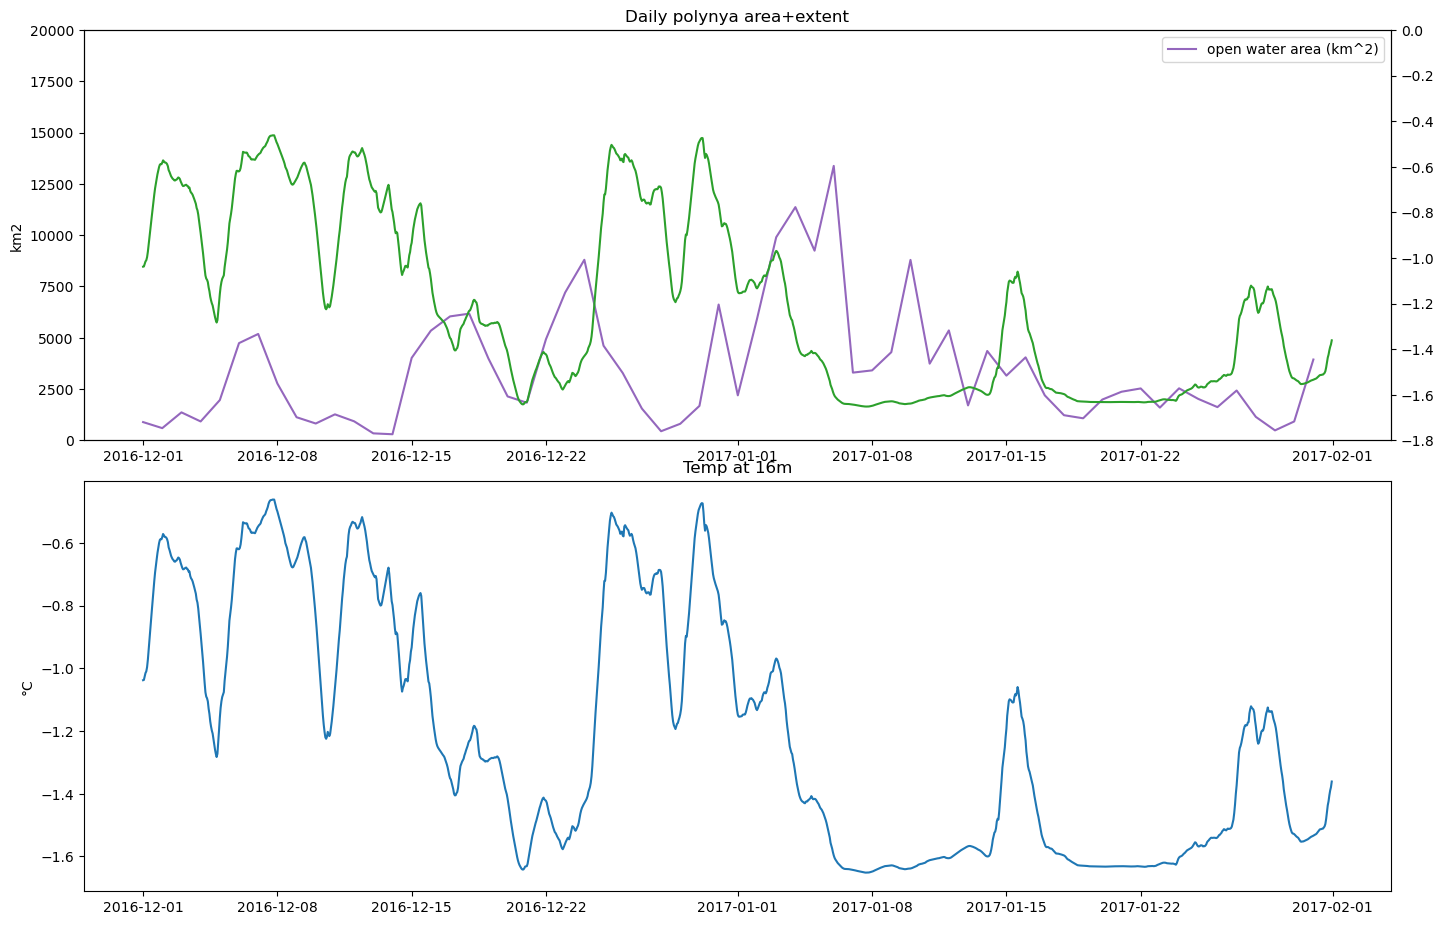

In [97]:
year = 2017

# importing the CSV files

#read in the data files
df_hourly_wind = pd.read_csv(f"/Users/reu/Box/Data/{year}wind_hourly.csv")
df_daily_size = pd.read_csv(f"/Users/reu/Box/Data/{year}SIC.csv")
df_daily_wind = pd.read_csv(f"/Users/reu/Box/Data/{year}wind_daily.csv")
df_upwelling = pd.read_csv(f"/Users/reu/Box/Data/{year}upwelling_hourly.csv")

#converting the times to the correct format
time_daily = pd.to_datetime(df_daily_size.time)
time_hourly = pd.to_datetime(df_hourly_wind.time)

#plotting stacked plots
fig, ax = plt.subplots(2, 1, figsize = (14,10))

labeldata = ("km2", "°C")

for i, (unit) in enumerate(labeldata):
    ax[i].set_ylabel(unit)
plt.tight_layout()
fig.subplots_adjust(top=.9)

# ax[0].plot(time_daily, df_daily_size.Open_water_extent_km2, 'tab:red', label = 'open water extent (km^2)')
# ax[0].set_title('Daily polynya extent')
ax[0].plot(time_daily, df_daily_size.Open_water_area_km2, 'tab:purple', label = 'open water area (km^2)')
ax[0].set_title('Daily polynya area+extent')
ax[0].set_ylim(0, 20000)

axtwin = ax[0].twinx()
axtwin.plot(time_hourly, df_upwelling.Tmean_C, 'tab:green', label = 'mean temp at 16 m')
ax[0].legend()
axtwin.set_ylim(-1.8, 0)

ax[1].plot(time_hourly, df_upwelling.Tmean_C, 'tab:blue', label = 'mean temp')
ax[1].set_title('Temp at 16m')
# ax[1].errorbar(time_hourly, df_upwelling.Tmean_C, yerr=yerr, label='both limits (default)')
# ax[1].set_ylim(0, 40000)